# Inverse Theory Assignment 2
*By Ryan Cox*

I'll start with some general code that'll be used all over.

In [11]:
using SparseArrays
using Distributions
using Krylov
using LinearAlgebra
using Plots
using LaTeXStrings
using BenchmarkTools

In [12]:
"""
Generate some synthetic data by applying gaussian noise to model

Parameters
    G::Matrix - Model kernel
    m::Vector - True parameters
    mean::Number - Mean of gaussian noise
    std::Number - Standard deviation of gaussian noise
"""
function FakeNormalData(G::Union{Matrix, SparseMatrixCSC}, m::Vector, mean::Number, std::Number)::Vector
    N = size(G)[1] # get num. of data elements
    gaussian = Normal(mean, std)
    n = rand(gaussian, N) # N gaussian random numbers
    d = G * m + n
end

FakeNormalData

# Q1 | Problem 3.1

Start with Eq 3.6
$$\frac{\partial E}{\partial m_1} = 2Nm_1 + 2m_2\sum_{i=1}^Nz_i - 2\sum_{i=1}^Nd_i = 0$$
$$\frac{\partial E}{\partial m_2} = 2m_1\sum_{i=1}^Nz_i + 2m_2\sum_{i=1}^Nz_i^2 - 2\sum_{i=1}^Nz_id_i = 0$$
Divide by two
$$Nm_1 + m_2\sum_{i=1}^Nz_i - \sum_{i=1}^Nd_i = 0$$
$$m_1\sum_{i=1}^Nz_i + m_2\sum_{i=1}^Nz_i^2 - \sum_{i=1}^Nz_id_i = 0$$
Shift last term
$$Nm_1 + m_2\sum_{i=1}^Nz_i = \sum_{i=1}^Nd_i$$
$$m_1\sum_{i=1}^Nz_i + m_2\sum_{i=1}^Nz_i^2 = \sum_{i=1}^Nz_id_i$$
Turn into a matrix
$$\begin{bmatrix} \sum_{i=1}^Nd_i \\ \sum_{i=1} Nz_id_i \end{bmatrix} = \begin{bmatrix} Nm_1 & m_2\sum_{i=1}^Nz_i \\ m_1\sum_{i=1}^Nz_i & m_2\sum_{i=1}^Nz_i^2 \\ \end{bmatrix}$$
Split out $\mathbf{m}$
$$\begin{bmatrix} \sum_{i=1}^Nd_i \\ \sum_{i=1} Nz_id_i \end{bmatrix} = \begin{bmatrix} N & \sum_{i=1}^Nz_i \\ \sum_{i=1}^Nz_i & \sum_{i=1}^Nz_i^2 \\ \end{bmatrix} \begin{bmatrix} m_1 \\ m_2 \end{bmatrix}$$
Solve for $\mathbf{m}$
$$\begin{bmatrix} m_1 \\ m_2 \end{bmatrix} = \begin{bmatrix} N & \sum_{i=1}^Nz_i \\ \sum_{i=1}^Nz_i & \sum_{i=1}^Nz_i^2 \\ \end{bmatrix}^{-1} \begin{bmatrix} \sum_{i=1}^Nd_i \\ \sum_{i=1} Nz_id_i \end{bmatrix}$$
Which is Eq 3.18, showing it is a valid solution

# Q2 | Problem 3.2

In [13]:
# Function taken from Assignment 1
"""Make NxN square matrix and fill it with triplets of a coefficent a.
In a row with index r, the cells [r, r], [r, r-1], [r, r-2] are filled.
Argument a multipes the entire matrix by scalar a.
For example TripletsMatrix(5, 1) produces the sparse matrix
   [1 0 0 0 0;
    1 1 0 0 0;
    1 1 1 0 0;
    0 1 1 1 0;
    0 0 1 1 1]"""
function TripletsMatrix(N::Int, a=1::Number)::SparseMatrixCSC  # a is probably unneccessary (vs hardcoding a=1) except in some odd cases, but including it is trivial.
    #= We are creating a matrix with COO, a coordinate list.
    For some k, row[k] gives row index, col[k] gives col index and val[k] gives the value for that coordinate pair.
    We create the matrices in advance then increment over vector coordiantes with k because it is reportedly faster than appending to matrices. =#
    
    if N < 2 error("N should be at least 2.") end
    
    col = Vector{Int64}(undef, 3*(N-1)) # 3*(N-1) should be the amount of nonzero values <- 3 from the first two rows and 3*(N-2) from the rest.
    row = Vector{Int64}(undef, 3*(N-1))
    val = Vector{Float64}(undef, 3*(N-1))
    k = 1 # This tracks our location in the COO vectors
    for i = 1:N # Row index.
        for j in i-2:i # Column index, for non-zero values. We don't write to any columns higher than i so this doesn't do anything weird in the last row.
            if j > 0 # To handle first two rows.
                col[k] = j
                row[k] = i
                val[k] = a
                k += 1
            end
        end
    end
    sparse(row, col, val) # Takes our vectors and turns them into a sparse matrix
end

"""
Find cov(m) given kernel G and standard deviation of data. Not efficent for large G.
"""
function Covariance(G::SparseMatrixCSC, std::Float64)::Matrix
    G = Matrix(G)
    std^2 * inv(transpose(G) * G)
end


function WithinTwoSTD(actual::Vector, est::Vector, std::Vector)::Int
    diff = abs.(actual .- est)
    twosigma = diff[diff .< (2*std)]
    length(twosigma)
end;

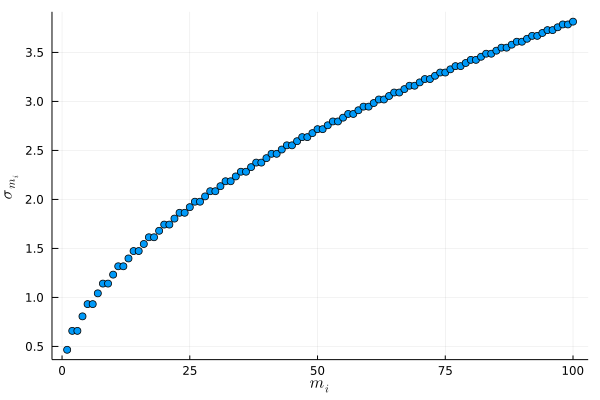

In [14]:
N = 100 # number of objects

# (A) Randomly assign true masses (0,1] to N objects
mTrue = 1 .- rand(Float64, N) # note subtraction from 1 to convert from [0,1)

# (B) create data kernal G
G = TripletsMatrix(N) 

# (C) Synthesise some data
d = FakeNormalData(G, mTrue, 0, 0.01)

# (D) Least squares solution for m.
# This lovely function, implemented by Krylov.jl, uses a conjugate gradient method to solve least squares quickly (~ 0.17 ms for this).
# See https://juliasmoothoptimizers.github.io/Krylov.jl/stable/solvers/ls/#Krylov.cgls
# I looked at the BiCG method suggested in Menke, but had some problems with the Julia equivilant.
# I also tried straight up solving the matrix eq:
#   m = inv(transpose(T) * G) * (transpose(G) * d)
# but that was (predicatably) slow.
(mEst, stats) = cgls(G, d)
# (E) Estimate variance of est. model params
# Slow but works for this small N
dDevEst = std(d)
mCov = Covariance(G, dDevEst)
mVar = diag(mCov) # Extract vector of variances for mEst from diagonal

# (F) Count number of model params within 2 std. of true value
mStd = mVar .^ 0.5
WithinTwoSTD(mTrue, mEst, mStd)
# (G) Plot model variance as function of index
plot(mStd, seriestype = :scatter, xlabel = L"m_i", ylabel = L"\sigma_{m_i}", legend=false) # std increases weith i

## Design Note

In [16]:
"""
An alternate function that achieves the same result as TripletsMatrix

The assignment question suggests "Try to see if you can construct G without using loops over columns and rows."
For the last assignment I wrote TripletsMatrix, which uses loops and COO. That isn't looping over columns and rows but it has some similarities.
TripletsMatrix does include a lot of looping, if not over rows and columns, so I decided to give it a go.
I discovered the function diagm() which constructs matrices from diagonals and created the short function below.
However, the benchmarks show that it is many times slower and uses much more memory.
I am hence only including it here to show the attempt.
"""
function TripletsMatrixDiag(N::Int, a=1::Number)
    d1 = fill(a, N)
    dn1 = fill(a, N-1)
    dn2 = fill(a, N-2)
    diagm(0 => d1, -1 => dn1, -2 => dn2)
end

display(@benchmark TripletsMatrix(1000))
display(@benchmark TripletsMatrixDiag(1000))

BechmarkTools.Trial: 10000 samples with 1 evaluations.
 Range (min … max):   40.300 μs …   8.060 ms  ┊ GC (min … max):  0.00% … 98.30%
 Time  (median):     119.000 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   123.321 μs ± 297.082 μs  ┊ GC (mean ± σ):  14.06% ±  6.07%

  █▆▄▂▂▁▂▁ ▃▄▆█▆▅▄▂▂▂▃▃▂▂▁                                      ▂
  █████████████████████████████▆▇▇▅▅▅▆▇▆▄▄▅▅▄▁▃▃▄▃▅▃▄▃▃▃▁▃▄▁▁▃▃ █
  40.3 μs       Histogram: log(frequency) by time        446 μs <

 Memory estimate: 188.75 KiB, allocs estimate: 20.

BechmarkTools.Trial: 1313 samples with 1 evaluations.
 Range (min … max):  1.986 ms … 13.964 ms  ┊ GC (min … max):  0.00% … 79.97%
 Time  (median):     3.012 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   3.778 ms ±  1.937 ms  ┊ GC (mean ± σ):  20.93% ± 23.33%

       █▆██                                                   
  ▃▅▄▄▄█████▆▅▄▅▄▄▄▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▄▄▄▃▃▃▃▃▃▃▃▂▂ ▃
  1.99 ms        Histogram: frequency by time        9.24 ms <

 Memory estimate: 7.74 MiB, allocs estimate: 6013.

# Q3 | Problem 3.4

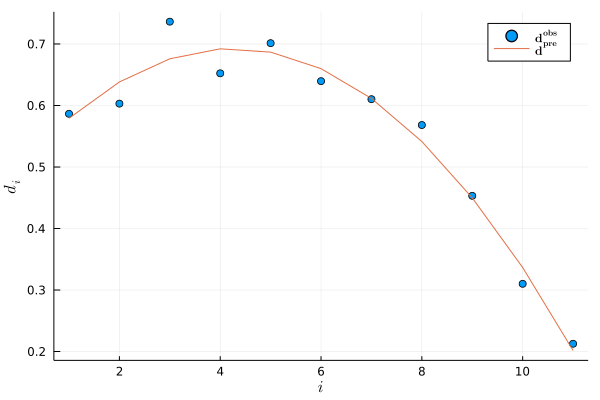

In [17]:
z = Vector(LinRange(0, 1, 11)) # (A) linear spacing, start=0, stop=10, # of values=11
# (B) assign true m by sampling uniform distribution
u = Uniform(-1, 1)
mTrue = rand(u, 4)
G = [ones(11) z z.^2 z.^3] # (C) Kernel
dObs = FakeNormalData(G, mTrue, 0, 0.05) # (D) synthetic data
(mEst, stats) = cgls(G, dObs) # (E) least squares
dPre = G * mEst # (F) calculate predicted data

plot(dObs, seriestype=:scatter, label=L"\mathbf{d^{obs}}", xlabel=L"i", ylabel=L"d_i") # (G) plot
plot!(dPre, label=L"\mathbf{d^{pre}}")

The model matches well when the data approximately follows a trend, even if it is non-linear. However, on some interations that data is spaced wildly and the model is a terrible fit. I believe these instances are caused by high Gaussian noise in the fake data and would become less prominent with a larger number of datapoints. The plot below demonstates this by increasing data to 250 points.

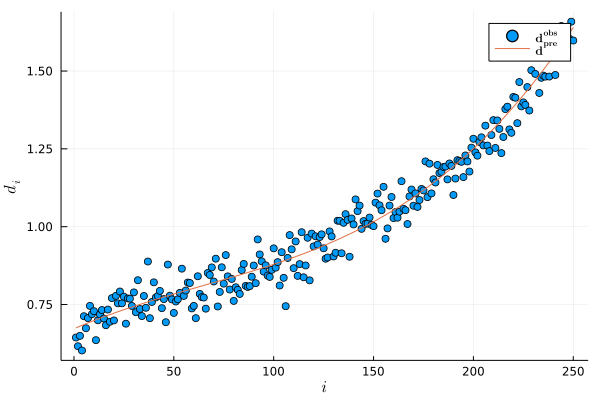

In [22]:
z = Vector(LinRange(0, 1, 250)) # (A) linear spacing, start=0, stop=10, # of values=11
# (B) assign true m by sampling uniform distribution
u = Uniform(-1, 1)
mTrue = rand(u, 4)
G = [ones(250) z z.^2 z.^3] # (C) Kernel
dObs = FakeNormalData(G, mTrue, 0, 0.05) # (D) synthetic data
(mEst, stats) = cgls(G, dObs) # (E) least squares
dPre = G * mEst # (F) calculate predicted data

plot(dObs, seriestype=:scatter, label=L"\mathbf{d^{obs}}", xlabel=L"i", ylabel=L"d_i") # (G) plot
plot!(dPre, label=L"\mathbf{d^{pre}}")

# Q4 | Problem 3.5

In [ ]:
z = Vector(LinRange(0, 1, 11)) # (A) linear spacing, start=0, stop=10, # of values=11
# (B) assign true m by sampling uniform distribution
u = Uniform(-1, 1)
mTrue = rand(u, 4)
G = [ones(11) z z.^2 z.^3] # (C) Kernel
dObs = FakeNormalData(G, mTrue, 0, 0.05) # (D) synthetic data

zp = 5
dp = 0
H = [1 zp zp^2 zp^3]
h = [dp]
lMatrix = [transpose(G)*G transpose(H); H 0]
rMatrix = vcat(transpose(G)*dObs, h)
display(lMatrix)
display(rMatrix)

@time display(bicgstabl(lMatrix, rMatrix))
@time display(inv(lMatrix)*rMatrix)

# dPre = G * mEst # (F) calculate predicted data

# plot(dObs, seriestype=:scatter, label=L"\mathbf{d^{obs}}", xlabel=L"i", ylabel=L"d_i") # (G) plot
# plot!(dPre, label=L"\mathbf{d^{pre}}")